# Devanagari Handwritten Character Dataset

The Devanagari Handwritten Character Dataset is a collection of images of handwritten characters from the Devanagari script, which includes characters used in several languages such as Hindi, Marathi, and Nepali. For classifying images from this dataset, supervised learning models, specifically convolutional neural networks (CNNs), are used due to their effectiveness in capturing spatial hierarchies in image data.

For more details on the dataset, visit this [link](https://archive.ics.uci.edu/dataset/389/devanagari+handwritten+character+dataset).

This notebook performs the following:

1. Downloads and unzips the dataset.
2. Preprocesses the dataset by resizing the images to dimensions of (28, 28) and normalizing the images to a range between 0 and 1.
3. Trains the model, reviews the results.
4. Provides a discussion on the obtained results.

### Downloading and unzipping the dataset.

In [ ]:
import requests
from zipfile import ZipFile
from io import BytesIO
from PIL import Image
import numpy as np
import os

# Download and unzip the dataset
zip_content = !wget "https://archive.ics.uci.edu/static/public/389/devanagari+handwritten+character+dataset.zip"
!mkdir -p "devanagari_dataset"
!unzip "devanagari+handwritten+character+dataset.zip" -d "devanagari_dataset"

# Define the directory path where the data is extracted
data_dir = "devanagari_dataset/DevanagariHandwrittenCharacterDataset"

Archive:  devanagari+handwritten+character+dataset.zip
replace devanagari_dataset/DevanagariHandwrittenCharacterDataset/Test/character_10_yna/10544.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Preprocessing the dataset

We'll use [PIL library](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.save) to load the images. Each image is then converted to a NumPy array and normalized before being returned as a list. Regarding the image resizing issue, it's important to note that resizing an image to a smaller size will inevitably lose some detail.

In [ ]:
# Function to load the labels and images
def load_images(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                image = Image.open(image_path)
                image = image.resize((28, 28), Image.LANCZOS)
                image = np.array(image)  # Convert the image to a numpy array
                image = image.astype('float32') / 255.0  # Normalize the image data
                images.append(image)
                labels.append(label)
    return images, labels #np.array(images), np.array(labels)


# Path to the training and testing directories
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

# Loading testing and training labels and images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

Plotting some of the images in the train dataset.

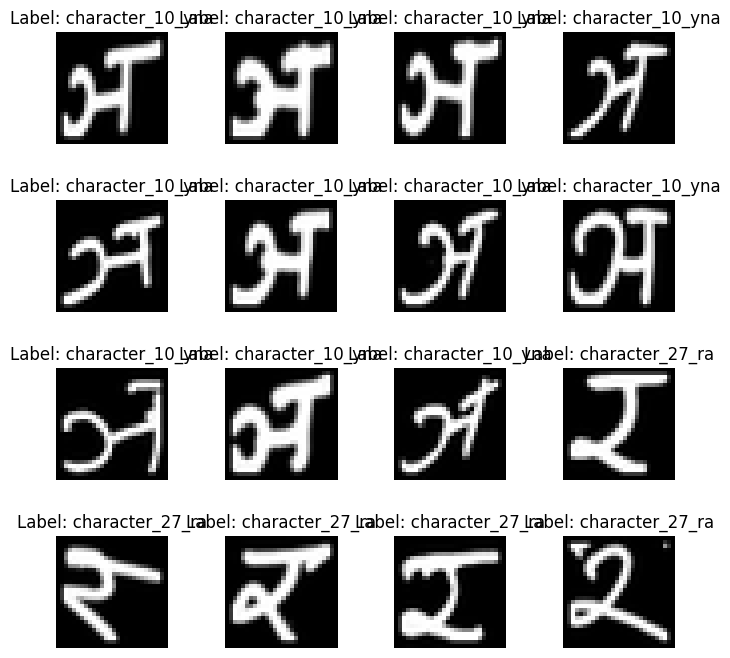

In [ ]:
import matplotlib.pyplot as plt

num_images_to_show = 16  # To show 16 images

# Set up the figure with a grid of subplots
plt.figure(figsize=(8, 8))  # Adjust the overall figure size as needed

for i in range(num_images_to_show):
    plt.subplot(4, 4, i + 1)  # Create subplots in a 4x4 grid
    indx = 6090+i*66

    plt.imshow(train_images[indx], cmap='gray')  # Use 'cmap' only if your images are in grayscale

    # Make sure to retrieve the correct label for each image
    label = train_labels[indx]
    plt.title(f"Label: {label}")

    plt.axis('off')  # Turn off the axis

# Adjust subplot parameters for a clean layout
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

The train_images and test_images are ensured to be NumPy arrays with the shape (num_samples, height, width, channels). The train_labels and test_labels are converted to NumPy arrays of type integer using label encoding.

Since SparseCategoricalCrossentropy is used, the labels are formatted as 1D integer arrays representing the class indices.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Convert lists of images to NumPy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)

# Ensure labels are NumPy arrays of integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Add channel dimension to images if necessary (for grayscale images)
if train_images.ndim == 3:
    train_images = train_images[..., np.newaxis]
if test_images.ndim == 3:
    test_images = test_images[..., np.newaxis]

### Model training

The model code defines a simple Sequential convolutional neural network (CNN) with three convolutional layers, each followed by max-pooling layers, and two dense layers at the end. The number of output units in the final dense layer matches the number of classes in the dataset, which is 46, as specified in this [paper](https://ieeexplore.ieee.org/document/7400041).

The model uses the ReLU activation function and the Adam optimizer.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set up the layers of the CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46))  # 46 classes for the Devanagari characters

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

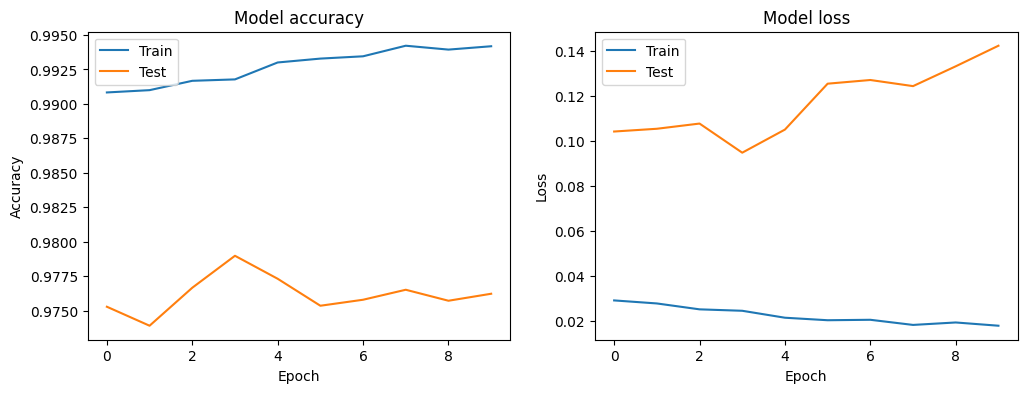

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Based on the results, the model's training loss decreases while the test (or validation) loss increases, which is a typical indication of overfitting. Overfitting occurs when a model learns the training data too well, including noise and details that do not generalize to new data. It is typically caused by the following:
- Complex models.
- Insufficient Regularization.
- Lack of Data Augmentation.
- Training Too Long.
- High Learning rate.

Different methods are applied below to address this issue and evaluate their effectiveness.

#### Learning Rate

The learning rate is decreased to 0.00001, which causes the model to take longer to train as the steps toward reaching the optimal solution become smaller.

In [ ]:
model_lr = model
# Create an optimizer with the desired learning rate
learning_rate = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model_lr.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model_lr.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels))

Epoch 1/30
2444/2444 [==============================] - 80s 32ms/step - loss: 3.6961 - accuracy: 0.0879 - val_loss: 3.3762 - val_accuracy: 0.1908
Epoch 2/30
2444/2444 [==============================] - 78s 32ms/step - loss: 2.7822 - accuracy: 0.3191 - val_loss: 2.3029 - val_accuracy: 0.4120
Epoch 3/30
2444/2444 [==============================] - 78s 32ms/step - loss: 2.1137 - accuracy: 0.4565 - val_loss: 1.9211 - val_accuracy: 0.5036
Epoch 4/30
2444/2444 [==============================] - 79s 32ms/step - loss: 1.8219 - accuracy: 0.5275 - val_loss: 1.6769 - val_accuracy: 0.5615
Epoch 5/30
2444/2444 [==============================] - 82s 34ms/step - loss: 1.6159 - accuracy: 0.5768 - val_loss: 1.4927 - val_accuracy: 0.6083
Epoch 6/30
2444/2444 [==============================] - 79s 32ms/step - loss: 1.4517 - accuracy: 0.6169 - val_loss: 1.3445 - val_accuracy: 0.6447
Epoch 7/30
2444/2444 [==============================] - 79s 33ms/step - loss: 1.3179 - accuracy: 0.6500 - val_loss: 1.2233 -

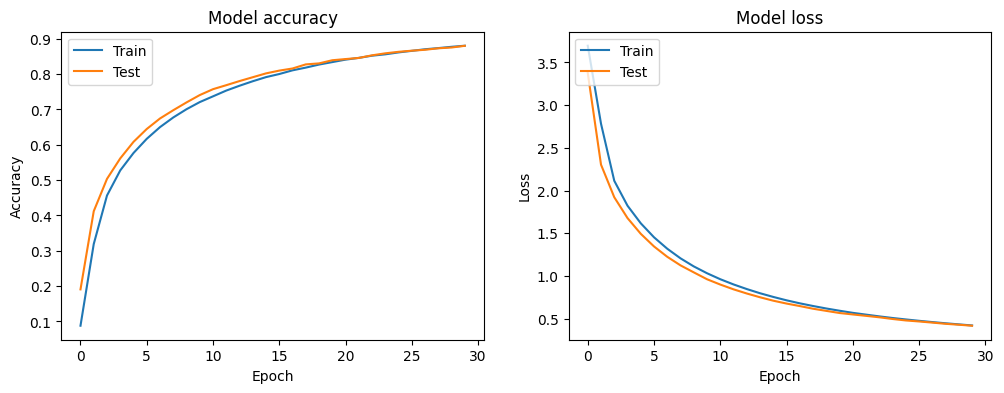

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#### L2 Regularization

L2 regularization is applied to penalize large weights that lead to overfitting while preserving the dataset's dimensions.

Epoch 1/10
2444/2444 [==============================] - 82s 33ms/step - loss: 0.6902 - accuracy: 0.8127 - val_loss: 0.2483 - val_accuracy: 0.9409
Epoch 2/10
2444/2444 [==============================] - 80s 33ms/step - loss: 0.2344 - accuracy: 0.9427 - val_loss: 0.2226 - val_accuracy: 0.9472
Epoch 3/10
2444/2444 [==============================] - 83s 34ms/step - loss: 0.1848 - accuracy: 0.9604 - val_loss: 0.1956 - val_accuracy: 0.9607
Epoch 4/10
2444/2444 [==============================] - 82s 33ms/step - loss: 0.1618 - accuracy: 0.9690 - val_loss: 0.2099 - val_accuracy: 0.9561
Epoch 5/10
2444/2444 [==============================] - 77s 32ms/step - loss: 0.1473 - accuracy: 0.9757 - val_loss: 0.2081 - val_accuracy: 0.9593
Epoch 6/10
2444/2444 [==============================] - 79s 32ms/step - loss: 0.1420 - accuracy: 0.9783 - val_loss: 0.1755 - val_accuracy: 0.9712
Epoch 7/10
2444/2444 [==============================] - 79s 32ms/step - loss: 0.1358 - accuracy: 0.9810 - val_loss: 0.1629 -

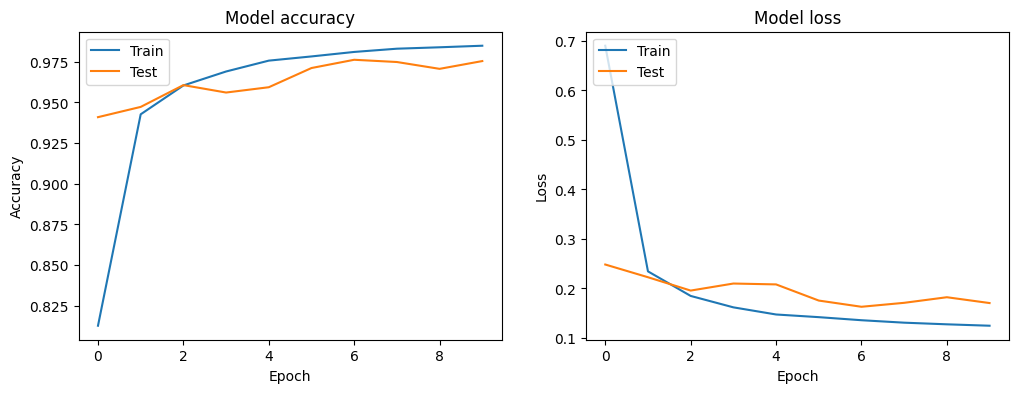

In [ ]:
from tensorflow.keras import regularizers

# Set up the layers of the CNN with L2 regularization
model_rg = models.Sequential()
model_rg.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1),
                        kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model_rg.add(layers.MaxPooling2D((2, 2)))
model_rg.add(layers.Conv2D(64, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model_rg.add(layers.MaxPooling2D((2, 2)))
model_rg.add(layers.Conv2D(64, (3, 3), activation='relu',
                        kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization

model_rg.add(layers.Flatten())
model_rg.add(layers.Dense(64, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001)))  # Added L2 regularization
model_rg.add(layers.Dense(46, kernel_regularizer=regularizers.l2(0.0001)))  # 46 classes, added L2 regularization

# Compile the model
model_rg.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model_rg.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#### Early stopping

Early stopping is implemented as a form of regularization, halting the training process if the model's performance on a validation set stops improving. Although early stopping does not show significant improvement in this case, it is included for learning purposes.

Epoch 1/10
2444/2444 [==============================] - 80s 32ms/step - loss: 0.1239 - accuracy: 0.9851 - val_loss: 0.1686 - val_accuracy: 0.9745
Epoch 2/10
2444/2444 [==============================] - 77s 31ms/step - loss: 0.1175 - accuracy: 0.9870 - val_loss: 0.1824 - val_accuracy: 0.9701
Epoch 3/10
2444/2444 [==============================] - 77s 31ms/step - loss: 0.1179 - accuracy: 0.9869 - val_loss: 0.1663 - val_accuracy: 0.9744
Epoch 4/10
2444/2444 [==============================] - 78s 32ms/step - loss: 0.1155 - accuracy: 0.9880 - val_loss: 0.1676 - val_accuracy: 0.9756
Epoch 5/10
2444/2444 [==============================] - 79s 32ms/step - loss: 0.1141 - accuracy: 0.9883 - val_loss: 0.1700 - val_accuracy: 0.9752
Epoch 6/10
2444/2444 [==============================] - 81s 33ms/step - loss: 0.1133 - accuracy: 0.9882 - val_loss: 0.1633 - val_accuracy: 0.9767
Epoch 7/10
2444/2444 [==============================] - 79s 32ms/step - loss: 0.1101 - accuracy: 0.9894 - val_loss: 0.1852 -

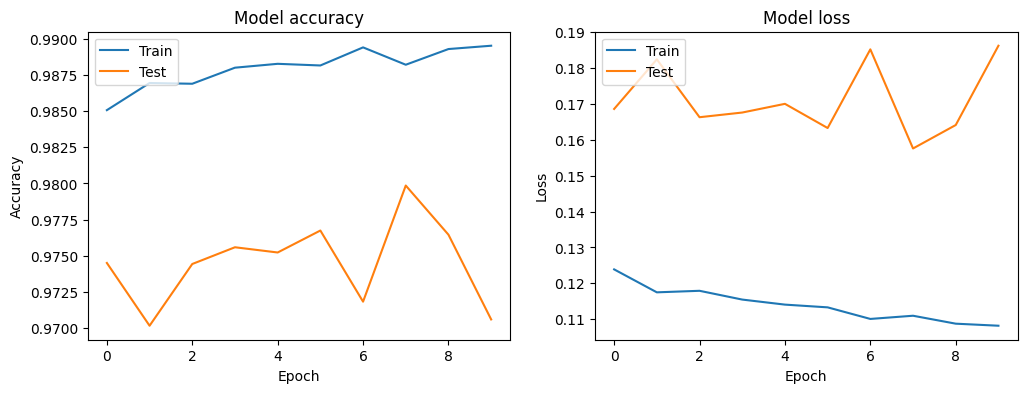

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_es = model

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Log when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Compile the model
model_es.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model with the early stopping callback
history = model_es.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]  # Include the early stopping callback here
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

### Discussion

Based on the results, decreasing the learning rate to 0.00001 and increasing the number of epochs to 30 improves the model's performance. The accuracy for both the training and validation datasets reaches approximately 88%, with a gradual increase in accuracy and a decrease in loss over epochs. The trends suggest effective learning, as the curves converge without signs of overfitting.

If the number of epochs is further increased, the following outcomes are expected:

- Continued Improvement: the model may continue to improve slightly, with both the training and validation accuracy possibly increasing a bit more as the model further fine-tunes its weights.

- Plateauing: the model may reach a point where additional training doesn't lead to better performance, indicated by a plateau in the accuracy and loss curves.

- Overfitting Risk: if trained for too many epochs, there's a risk of overfitting, where the model starts to learn the noise and specific details of the training set that do not generalize to new data. This would be observed as a continued decrease in training loss, but an increase or plateau in validation loss.

Early stopping can mitigate overfitting by halting training before the specified number of epochs if the validation loss fails to improve for a set number of consecutive epochs (determined by the 'patience' parameter).